#EfficientSAM + YOLOWorld

This notebook shows how to use YOLOWorld along with EfficientSAM


*   YOLOWorld is used for zero-shot object detection using text prompts
*   EfficientSAM performs segmentation on bounding boxes that were detected by YOLOWorld



## Installations and imports


In [ ]:
!git clone https://github.com/yformer/EfficientSAM.git

# !pip3 install autodistill-efficient-yolo-world
# !pip install autodistill
# !pip install roboflow
!pip install -q inference-gpu[yolo-world]==0.9.12rc1
!pip install -q supervision==0.19.0rc3

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io
import cv2
import supervision as sv

import os

from tqdm import tqdm
from inference.models.yolo_world.yolo_world import YOLOWorld
import numpy as np
import copy

[03/09/24 15:23:00] WARNING  Your inference package version 0.9.12rc1 is out of date! Please upgrade ]8;id=610723;file:///usr/local/lib/python3.10/dist-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=91920;file:///usr/local/lib/python3.10/dist-packages/inference/core/__init__.py#35\35]8;;\
                             to version 0.9.15 of inference for the latest features and bug fixes by               
                             running `pip install --upgrade inference`.                                            

##Download example image and video or upload yours


In [3]:
HOME = os.getcwd()
print(HOME)

/content


In [4]:
!wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

In [9]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"
# SOURCE_IMAGE_PATH = "/content/DSC01137.JPG"
SOURCE_VIDEO_PATH = f"{HOME}/yellow-filling.mp4"
# SOURCE_VIDEO_PATH   = "/content/pexels-anton-mislawsky-5741488 (2160p).mp4"

##Yolo-world for object detection



In [6]:
model = YOLOWorld(model_id="yolo_world/l")

Define the classes for detection

In [7]:
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue","window"]
# classes = [ "dog"]

model.set_classes(classes)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 61.1MiB/s]


Perform inference with yolo world

In [10]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image,confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

Visualise the object detection predictions with supervision tools

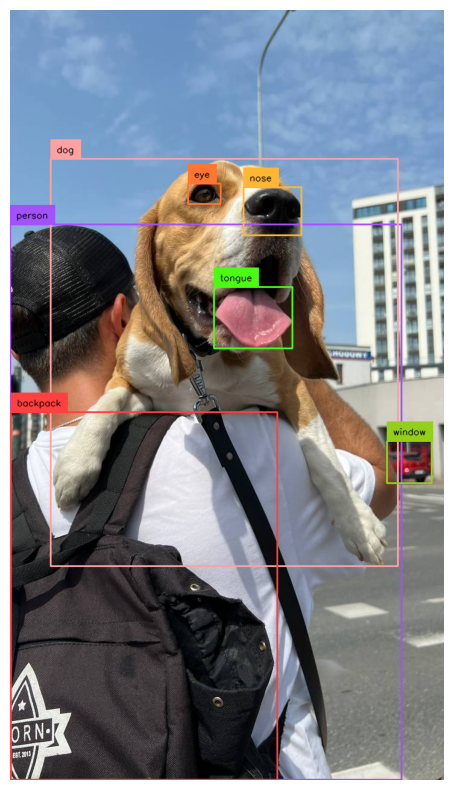

In [11]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=1, text_scale=0.5, text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## EfifcientSAM + YOLOworld


In the code below, we customized the class of EfficientYoloWorld from autodistill_efficient_yolo_world

In [12]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load model in cuda
def load(device: torch.device) -> torch.jit.ScriptModule:
    if device.type == "cuda":
        # model = torch.jit.load(HOME + "/.autodistill/" + GPU_EFFICIENT_SAM_CHECKPOINT)
        model = torch.jit.load("/content/EfficientSAM/torchscripted_model/efficient_sam_vitt_torchscript.pt")
        model = model.to(device)
    else:
        # model = torch.jit.load(HOME + "/.autodistill/" + CPU_EFFICIENT_SAM_CHECKPOINT)
        model = torch.jit.load("/content/EfficientSAM/torchscripted_model/efficient_sam_vitt_torchscript.pt")
        model = model.to(device)
        print("No available CUDA, the model was loaded in CPU")

    model.eval()
    return model

class EfficientYOLOWorld_custom():

    def __init__(self):
        self.detection_model = YOLOWorld(model_id="yolo_world/l")
        self.segmentation_model = load(device=DEVICE)


    def box_segmentation_inference(self,image, pts_sampled, pts_labels,device ):

        image_np = image
        img_tensor = ToTensor()(image_np)
        pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
        pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
        predicted_logits, predicted_iou = self.segmentation_model(
            img_tensor[None, ...].to(device),
            pts_sampled.to(device),
            pts_labels.to(device),
        )
        sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
        predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
        predicted_logits = torch.take_along_dim(
            predicted_logits, sorted_ids[..., None, None], dim=2
        )

        return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

    def predict_with_yoloworld(self,classes, input: str=None,frame=None, confidence: int = 0.5) -> sv.Detections:

        if input != None:
          image = cv2.imread(input)
        else:
          image = frame
        #predict using non max suppresion (NMS) to Eliminate Double Detection
        model = self.detection_model
        model.set_classes(classes)
        results = model.infer(image,confidence=confidence)
        result = sv.Detections.from_inference(results).with_nms(threshold=0.1)

        return result

    def predict_with_efficientsam(self, detections_from_yolo,input: str=None,frame=None) -> sv.Detections:

        if input != None:
          image = cv2.imread(input)
        else:
          image = frame

        detections_from_yolo.mask = np.array([None] * len(detections_from_yolo.xyxy))

        for i, [x_min, y_min, x_max, y_max] in enumerate(detections_from_yolo.xyxy):
            y_min, y_max = int(y_min), int(y_max)
            x_min, x_max = int(x_min), int(x_max)
            input_image = image[y_min:y_max, x_min:x_max]
            input_point = np.array([[x_min, y_min], [x_max, y_max]])
            input_label = np.array([2,3])
            image_for_inference = image
            mask_efficient_sam_vits = self.box_segmentation_inference(image_for_inference, input_point, input_label,DEVICE)

            detections_from_yolo.mask[i] = mask_efficient_sam_vits

        return detections_from_yolo


Model initialisation and class definition

In [13]:
base_model = EfficientYOLOWorld_custom()

classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue","window"]
# classes = ["window"]
# predict on an image
result = base_model.predict_with_yoloworld(classes,input=SOURCE_IMAGE_PATH, confidence=0.0005)

In [ ]:
result

Visualise the object detection predictions

In [16]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=3)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

By default, `sv.LabelAnnotator` displays only the names of objects. To also view the confidence levels associated with each detection, we must define custom `labels` and pass them to `sv.LabelAnnotator`.

In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)

# labels = [
#     f"{classes[class_id]} {confidence:0.3f}"
#     for class_id, confidence
#     in zip(result.class_id, result.confidence)
# ]
labels = [
    f"{index + 1}: {classes[class_id]} {confidence:0.3f}"
    for index, (class_id, confidence)
    in enumerate(zip(result.class_id, result.confidence))
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, result)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, result, labels=labels)
sv.plot_image(annotated_image, (10, 10))

In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, result)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, result)
sv.plot_image(annotated_image, (10, 10))

Visualise the segmentation results

In [ ]:
segmented_result = base_model.predict_with_efficientsam(copy.deepcopy(result),input=SOURCE_IMAGE_PATH)
mask_annotator = sv.MaskAnnotator()
annotated_frame = mask_annotator.annotate(
	scene=annotated_image,
	detections=segmented_result,
)

sv.plot_image(annotated_frame)

## Video Processing

The [`get_video_frames_generator`](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.

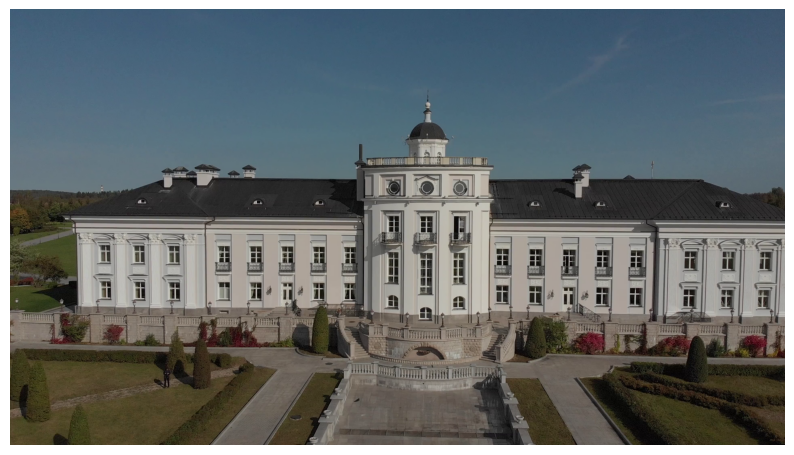

In [ ]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (10, 10))

### YOLOWorld


In [ ]:
model = YOLOWorld(model_id="yolo_world/l")

In [ ]:
classes = ["yellow filling"]
model.set_classes(classes)

In [ ]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

In [ ]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

In [ ]:
annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

###Apply efficientSAM along with YOLOWorld

In [ ]:
base_model = EfficientYOLOWorld_custom()

# classes = ["yellow filling"]
classes = ["window"]
# predict on an image
result = base_model.predict_with_yoloworld(classes, frame=frame, confidence=0.0001)

In [ ]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=1, text_scale=0.5, text_color=sv.Color.BLACK)

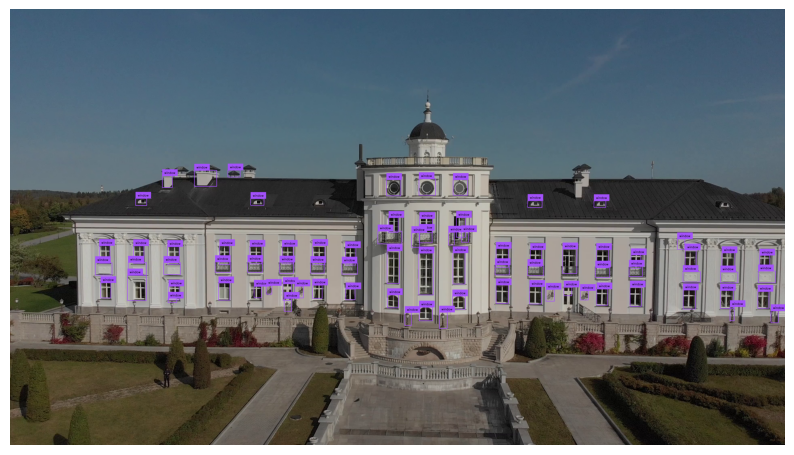

In [ ]:
annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, result)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, result)
sv.plot_image(annotated_image, (10, 10))

input a copy od result, so we can keep the results from yolo_world unchanged. This is required in case that we want to edit these results, i.e. remove some bounding boxes etc

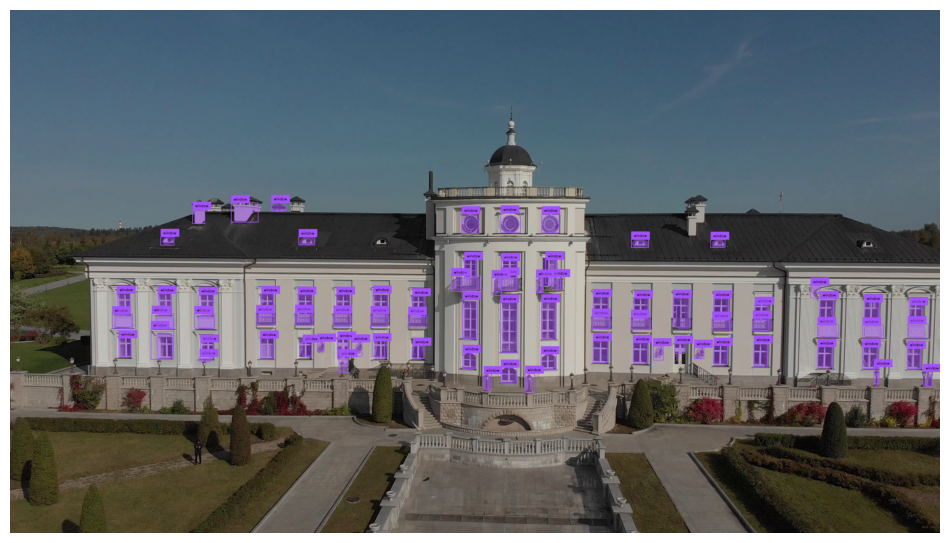

In [ ]:
segmented_result = base_model.predict_with_efficientsam(copy.deepcopy(result),frame=frame)
mask_annotator = sv.MaskAnnotator()
annotated_frame = mask_annotator.annotate(
	scene=annotated_image,
	detections=segmented_result,
)

sv.plot_image(annotated_frame)

### Filtering Detections by Area

 If a detection occupies more than 10% of the frame's total area, it will be discarded.

We can use [`VideoInfo.from_video_path`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo) to learn basic information about our video, such as duration, resolution, or FPS.

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=3840, height=2160, fps=25, total_frames=144)

Knowing the frame's resolution allows us to easily calculate its total area, expressed in pixels.

In [ ]:
width, height = video_info.resolution_wh
frame_area = width * height
frame_area

8294400

On the other hand, by using [`sv.Detections.area`](https://supervision.roboflow.com/develop/detection/core/#supervision.detection.core.Detections.area) property, we can learn the area of each individual bounding box.

In [ ]:
detections = result

In [ ]:
detections = detections[(detections.area / frame_area) < 0.10]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

In [ ]:
segmented_result = base_model.predict_with_efficientsam(copy.deepcopy(detections),frame=frame)

In [ ]:

mask_annotator = sv.MaskAnnotator()
annotated_frame = mask_annotator.annotate(
	scene=annotated_image,
	detections=segmented_result,
)

sv.plot_image(annotated_frame)

### Final Result

Finally, we are ready to process our entire video. Now in truth we can appreciate the speed of YOLO-World.

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/facade_output_2.mp4"

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

width, height = video_info.resolution_wh
frame_area = width * height
frame_area

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # predict the bounding boxes via YOLOWorld
        detections = base_model.predict_with_yoloworld(classes, frame=frame, confidence=0.0001)

        #remove the bbs that cover more than 10% of the whole frame
        detections = detections[(detections.area / frame_area) < 0.10]

        #segment the remaining bbs via efficientSAM
        detections = base_model.predict_with_efficientsam(detections,frame=frame)

        #Annotate the bbs along with the segmentations mask and save
        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = mask_annotator.annotate(scene=annotated_frame,detections=detections)
        sink.write_frame(annotated_frame)

100%|██████████| 144/144 [1:06:59<00:00, 27.91s/it]


In [ ]:
from google.colab import files
files.download(TARGET_VIDEO_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>